### Third Party Libraries

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import math
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
plt.rcParams["figure.figsize"] = (8,8)
import seaborn as sb
from umap import UMAP
import configparser as cp
os.environ["CUDA_VISIBLE_DEVICES"]="1"


### Import Configuration File

Configuration file is read and network model parameters are saved as local variables. These parameters are used to define the structure of the supervised encoder, decoder, and CGAN.

In [2]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

config = cp.ConfigParser()
config.read('config.py')

rna_hidden_dim_1 = int(config.get('AE', 'RNA_Layer1'))
rna_hidden_dim_2 = int(config.get('AE', 'RNA_Layer2'))
rna_latent_dim = int(config.get('AE', 'RNA_Latent'))
translate_hidden_dim = int(config.get('AE', 'Translate_Layer1'))
l2_norm_dec = float(config.get('AE', 'L2_Norm_AE'))
l2_norm_kl = float(config.get('AE', 'L2_Norm_KL'))
learning_rate_kl = float(config.get('AE', 'Learning_Rate_KL'))
learning_rate_ae = float(config.get('AE', 'Learning_Rate_AE'))

Z_dim = int(config.get('CGAN', 'Z_dim'))
gen_dim1 = int(config.get('CGAN', 'Gen_Layer1'))
gen_dim2 = int(config.get('CGAN', 'Gen_Layer2'))
det_dim = int(config.get('CGAN', 'Det_Layer1'))
learning_rate_cgan = float(config.get('CGAN', 'Learning_Rate'))
l2_norm_cgan = float(config.get('CGAN', 'L2_Lambda'))

### Function to Plot Data
Custom function that takes a matrix where each row is a sample and each column is a features, and generates either a plot for the UMAP or TSNE representation of the data. The function only plots samples labeled whose maximum value is IghM, IghG1, IghG2b, and IghG3.

In [3]:
def plot_data(rna, relative, relative_list, title, method, colors):

    if method == "tsne":
        tsne = TSNE()
        results = np.array(tsne.fit_transform(rna))
        
    if method == "umap":
        umap = UMAP()
        results = np.array(umap.fit_transform(rna))

    cl = np.argmax(relative, axis=1)
    plot_set = ["Ighm", "Ighg1", "Ighg2b", "Ighg3"]
    filt = []
    filt_col = []

    for i in range(0,len(cl)):
        if relative_list[cl[i]] in plot_set:
            filt.append(i)
            filt_col.append(colors[i])
            
    ighm_patch = mpatches.Patch(color='green', label='IghM')
    ighg1_patch = mpatches.Patch(color='blue', label='IghG1')
    ighg2b_patch = mpatches.Patch(color='purple', label='IghG2b')
    ighg3_patch = mpatches.Patch(color='pink', label='IghG3')
    csr_patch = mpatches.Patch(color='tan', label='CSR')

    filt = np.array(filt)
    plt.scatter(results[filt,0], results[filt,1], c = filt_col, s=8)
    
    plt.title(title.title() + " (" + method.upper() + ")")
    plt.legend(handles=[ighm_patch, ighg1_patch, ighg2b_patch, ighg3_patch, csr_patch])

### Load Data

RNA data, the relative abundance of Igh genes, and the subclass for each cell are loaded. Only samples with both RNA data and relative expression data are kept. Here, RNA data is represented as mutual nearest neighbor (MNN) values and relative expression is the relative abundance based on TPM.

In [5]:
rna_data = pd.read_csv("data/mnn.nocos.full.genes.tsv", header=0, index_col=0, sep="\t")
relative_data = pd.read_csv("data/ighc.genes.relative.tsv", index_col=0, header=0, sep="\t")
color_df = pd.read_csv("data/C_labels.txt", index_col=1, header=None, sep="\t")

relative_data = relative_data.filter(rna_data.columns.str.replace(".",""), axis=1)
sample_list = rna_data.columns.str.replace(".","").values
relative_data = relative_data.filter(sample_list, axis=1)


### Color Map
Colors are mapped to the different subclasses for use in future plots.

In [6]:
color_list = []
class_list = []

for i in relative_data.columns.values:
    if i in color_df.index.values: 
        subtype = color_df.loc[i].values
        if subtype == "IgM":
            color_list.append("green")
            class_list.append("Ighm")

        elif subtype == "IgA":
            color_list.append("orange")
            class_list.append("Igha")

        elif subtype == "igD":
            color_list.append("yellow")
            class_list.append("Ighd")

        elif subtype == "IgE":
            color_list.append("red")
            class_list.append("Ighe")

        elif subtype == "IgG1":
            color_list.append("blue")
            class_list.append("Ighg1")

        elif subtype == "IgG2b":
            color_list.append("purple")
            class_list.append("Ighg2b")

        elif subtype == "IgG2c":
            color_list.append("brown")
            class_list.append("Ighg2c")

        elif subtype == "IgG3":
            color_list.append("pink")
            class_list.append("Ighg3")
    else:
        color_list.append("tan")
        class_list.append("CSR")     

### Heatmap
A heatmap is generated using the relative expression of Igh genes. Samples are clustered to show different cell types as well as class switching.

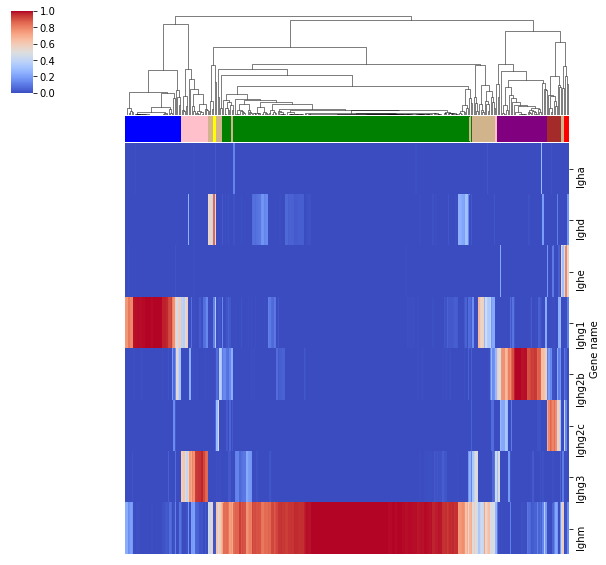

In [7]:
norm_relative = np.log2(relative_data + 1) 


heat_map = sb.clustermap(relative_data, xticklabels=False, yticklabels=relative_data.index.values, 
                         cmap='coolwarm', method='average', metric='euclidean', row_cluster=False,
                         col_colors=color_list)
plt.ylabel('')
plt.show()

### Save Genes Used
Save the genes used by the model in a text file.

In [8]:
gene_list = rna_data.index.values
np.savetxt("genes_used.txt", gene_list, fmt="%s")

relative_list = relative_data.index.values
cl = np.argmax(np.transpose(relative_data.values), axis=1)

rna_data = rna_data.transpose().values
relative_data = relative_data.transpose().values

print("Using %d genes" % (len(gene_list)))

Using 41671 genes


### UMAP and tSNE of Input Data

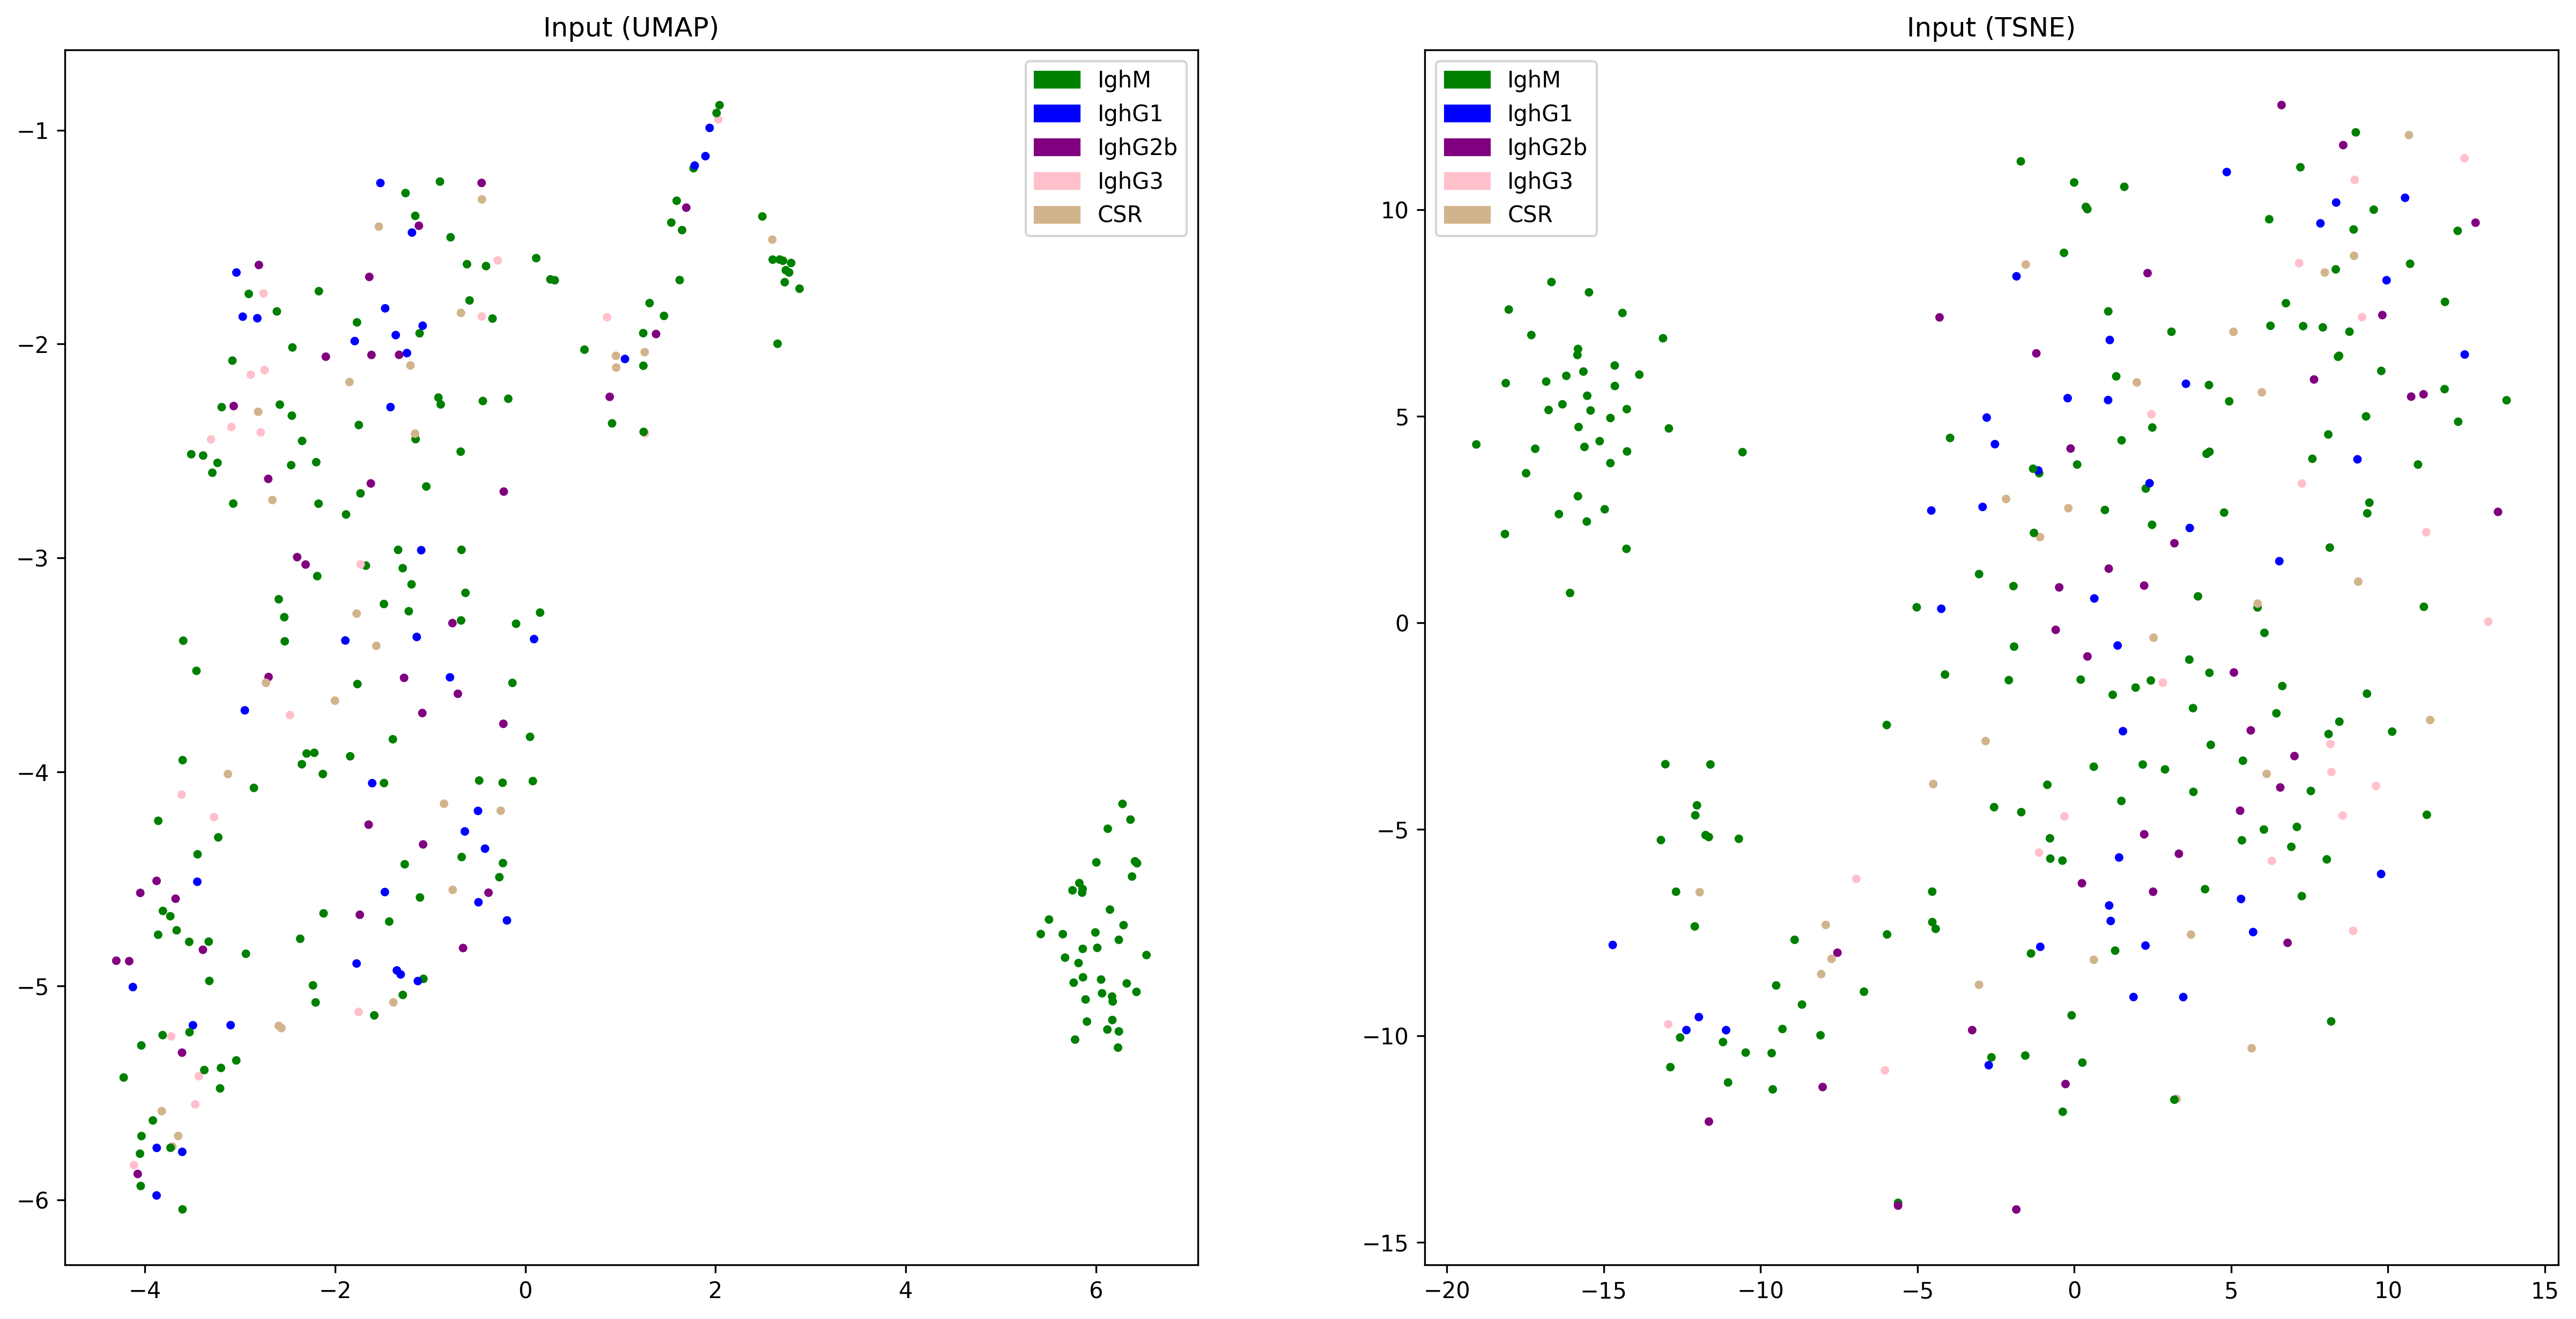

In [9]:
scaler = StandardScaler().fit(rna_data)
norm_rna_data = np.clip(scaler.transform(rna_data),-3,3)

plt.figure(figsize=(20,10), dpi=300)
plt.subplot(121)
plot_data(rna_data, np.array(relative_data), relative_list, "input", "umap", color_list)
plt.subplot(122)
plot_data(rna_data, np.array(relative_data), relative_list, "input", "tsne", color_list)

plt.show()

## 10-Fold Cross-Validation of Supervised Autoencoder
The supervised autoencoder is evaluated using 10-fold cross-validation. For each partition, a supervised encoder is first trained using the relative abundance of the Igh genes. Afterwards, a decoder is trained to reconstruct the gene expression data. Reconstruction of each blind test set is stored for visualization and evaluation.

In [10]:
color_list = np.array(color_list)
class_list = np.array(class_list)

scatter_colors = list([])
scatter_labels = list([])

rna_dim = norm_rna_data.shape[1]
relative_dim = relative_data.shape[1]
run = 0
sss = StratifiedKFold(n_splits=10)
for train_index, test_index in sss.split(sample_list, cl):
    sample_train, sample_test = sample_list[train_index], sample_list[test_index]
    rna_train, rna_test = rna_data[train_index], rna_data[test_index]
    relative_train, relative_test = relative_data[train_index], relative_data[test_index]
    scatter_colors = scatter_colors + list(color_list[test_index])
    scatter_labels = scatter_labels + list(class_list[test_index])
    
    scaler = StandardScaler().fit(rna_train)
    norm_rna_train = scaler.transform(rna_train).clip(-10,10)
    norm_rna_test = scaler.transform(rna_test).clip(-10,10)
    
    reg_kl = tf.keras.regularizers.l2(l2_norm_kl)
    cv_kl_model = tf.keras.Sequential([

        tf.keras.layers.Dense(rna_hidden_dim_1, activation='relu',
            kernel_regularizer=reg_kl, input_shape=(len(gene_list),)),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(rna_hidden_dim_2, activation='relu',
           kernel_regularizer=reg_kl),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(rna_latent_dim, activation='sigmoid', name='latent_layer',
            kernel_regularizer=reg_kl),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(translate_hidden_dim, activation='relu',
            kernel_regularizer=reg_kl),
        tf.keras.layers.Dropout(0.3),

        tf.keras.layers.Dense(len(relative_list), activation=tf.nn.softmax,
            kernel_regularizer=reg_kl, name='relative_prediction')
    ])

    es_cb_kl = tf.keras.callbacks.EarlyStopping('val_kullback_leibler_divergence', patience=100, restore_best_weights=True)
    cv_kl_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate_kl), loss=tf.keras.losses.KLD, metrics=['kullback_leibler_divergence'])
    
    cv_kl_model.fit(norm_rna_train, relative_train, epochs=10000, callbacks=[es_cb_kl], validation_split=0.1, verbose=0, batch_size=1024)
    cv_kl_model.fit(norm_rna_train, relative_train, epochs=5, verbose=0, batch_size=1024)
    cv_kl_model.evaluate(rna_test, relative_test)

    latent = tf.keras.Model(inputs=cv_kl_model.input, outputs=cv_kl_model.get_layer('latent_layer').output)
    latent_train = latent.predict(norm_rna_train)
    latent_test = latent.predict(norm_rna_test)
    
    reg_dec = tf.keras.regularizers.l2(l2_norm_dec)

    cv_dec_model = tf.keras.Sequential([
        tf.keras.layers.Dense(rna_hidden_dim_2, activation='relu', input_shape=(rna_latent_dim,),
            kernel_regularizer=reg_dec),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(rna_hidden_dim_1, activation='relu',
            kernel_regularizer=reg_dec, bias_regularizer=reg_dec),
        tf.keras.layers.BatchNormalization(),

        tf.keras.layers.Dense(len(gene_list), activation="linear", name='rna_reconstruction',
            kernel_regularizer=reg_dec),
    ])

    es_cb_dec = tf.keras.callbacks.EarlyStopping('val_mean_squared_error', patience=40, restore_best_weights=True)
    cv_dec_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate_ae), loss=tf.keras.losses.MSE, metrics=['mse'])
    
    cv_dec_model.fit(latent_train, rna_train, epochs=100000, callbacks=[es_cb_dec], validation_split=0.1, verbose=0, batch_size=1024)
    cv_dec_model.fit(latent_train, rna_train, epochs=5, verbose=0, batch_size=1024)
    cv_dec_model.evaluate(latent_test, rna_test)
    decoded_test = cv_dec_model.predict(latent_test)

    if run == 0:
        cv_pred_df = pd.DataFrame(data = decoded_test, index=sample_test, columns=gene_list)
        cv_true_df = pd.DataFrame(data = rna_test, index=sample_test, columns=gene_list)
    else:
        cv_pred_df = pd.concat([cv_pred_df, pd.DataFrame(data = decoded_test, index=sample_test, columns=gene_list)])
        cv_true_df = pd.concat([cv_true_df, pd.DataFrame(data = rna_test, index=sample_test, columns=gene_list)])
    
    run += 1
    tf.reset_default_graph()

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
28/28 [==============================] - 0s 394us/sample - loss: 0.2011 - mean_squared_error: 0.1769


Scatterplots are generated for particular genes of interest. Here, the x-axis is the observed value and the y-axis is the reconstructed value.

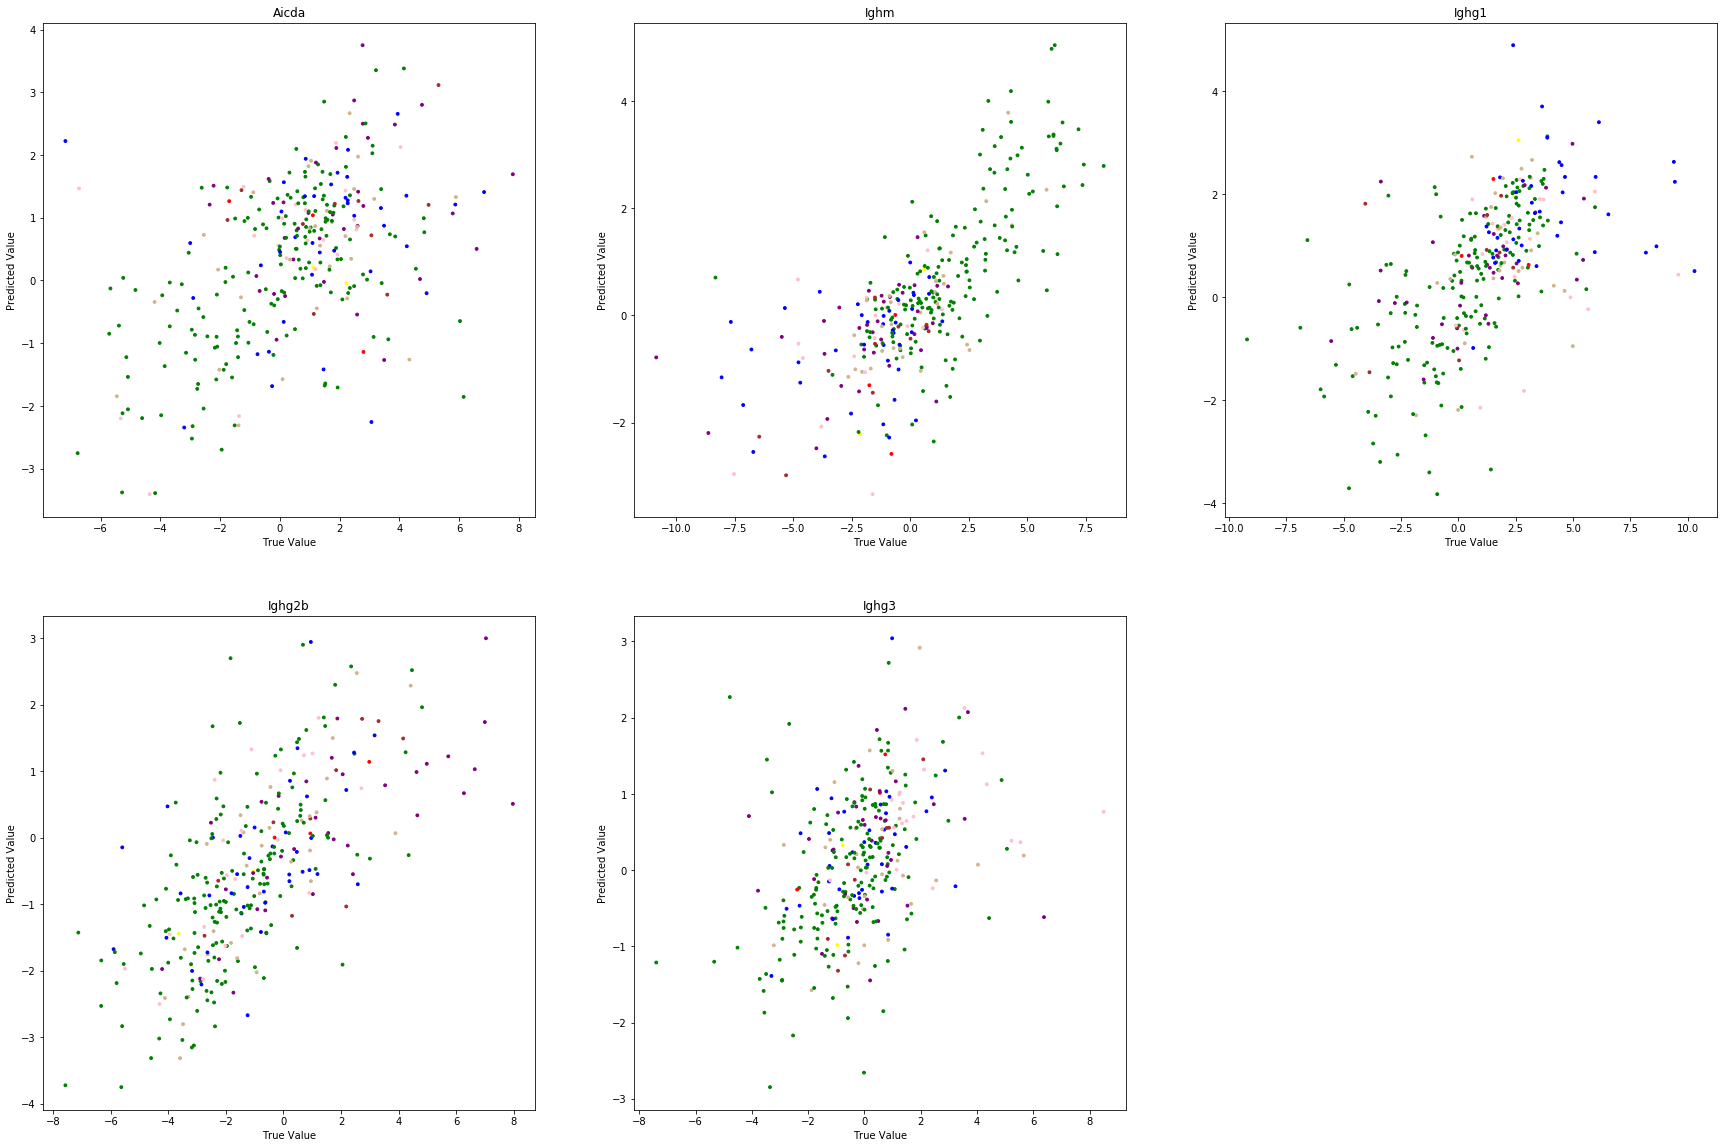

In [12]:
plt.figure(figsize=(30,20))
sub_idx = 231
for g in ["Aicda","Ighm", "Ighg1", "Ighg2b", "Ighg3"]:
    plt.subplot(sub_idx)
    plt.scatter(cv_true_df[g], cv_pred_df[g], c=scatter_colors, s=8)
    plt.title(g)
    plt.xlabel("True Value")
    plt.ylabel("Predicted Value")
    sub_idx += 1


## Supervised Encoder

A full encoder is trained using the relative abundance of Igh genes in order to structure the latent space in more meaningful way.

In [17]:
scaler = StandardScaler().fit(rna_data)
norm_rna_data = np.clip(scaler.transform(rna_data),-3,3)
  
reg_kl = tf.keras.regularizers.l2(l2_norm_kl)
kl_model = tf.keras.Sequential([

    tf.keras.layers.Dense(rna_hidden_dim_1, activation='relu',
        kernel_regularizer=reg_kl, input_shape=(len(gene_list),)),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(rna_hidden_dim_2, activation='relu',
        kernel_regularizer=reg_kl),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(rna_latent_dim, activation='sigmoid', name='latent_layer',
        kernel_regularizer=reg_kl),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(translate_hidden_dim, activation='relu',
        kernel_regularizer=reg_kl),
    tf.keras.layers.Dropout(0.3),

    tf.keras.layers.Dense(len(relative_list), activation=tf.nn.softmax,
        kernel_regularizer=reg_kl, name='relative_prediction')
])

es_cb_kl = tf.keras.callbacks.EarlyStopping('val_kullback_leibler_divergence', patience=100, restore_best_weights=True)
kl_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate_kl), loss=tf.keras.losses.KLD, metrics=['kullback_leibler_divergence'])
kl_model.fit(norm_rna_data, relative_data, epochs=10000, callbacks=[es_cb_kl], validation_split=0.1, verbose=0, batch_size=1024)
kl_model.fit(norm_rna_data, relative_data, epochs=5, verbose=0, batch_size=1024)


## Latent UMAP and tSNE

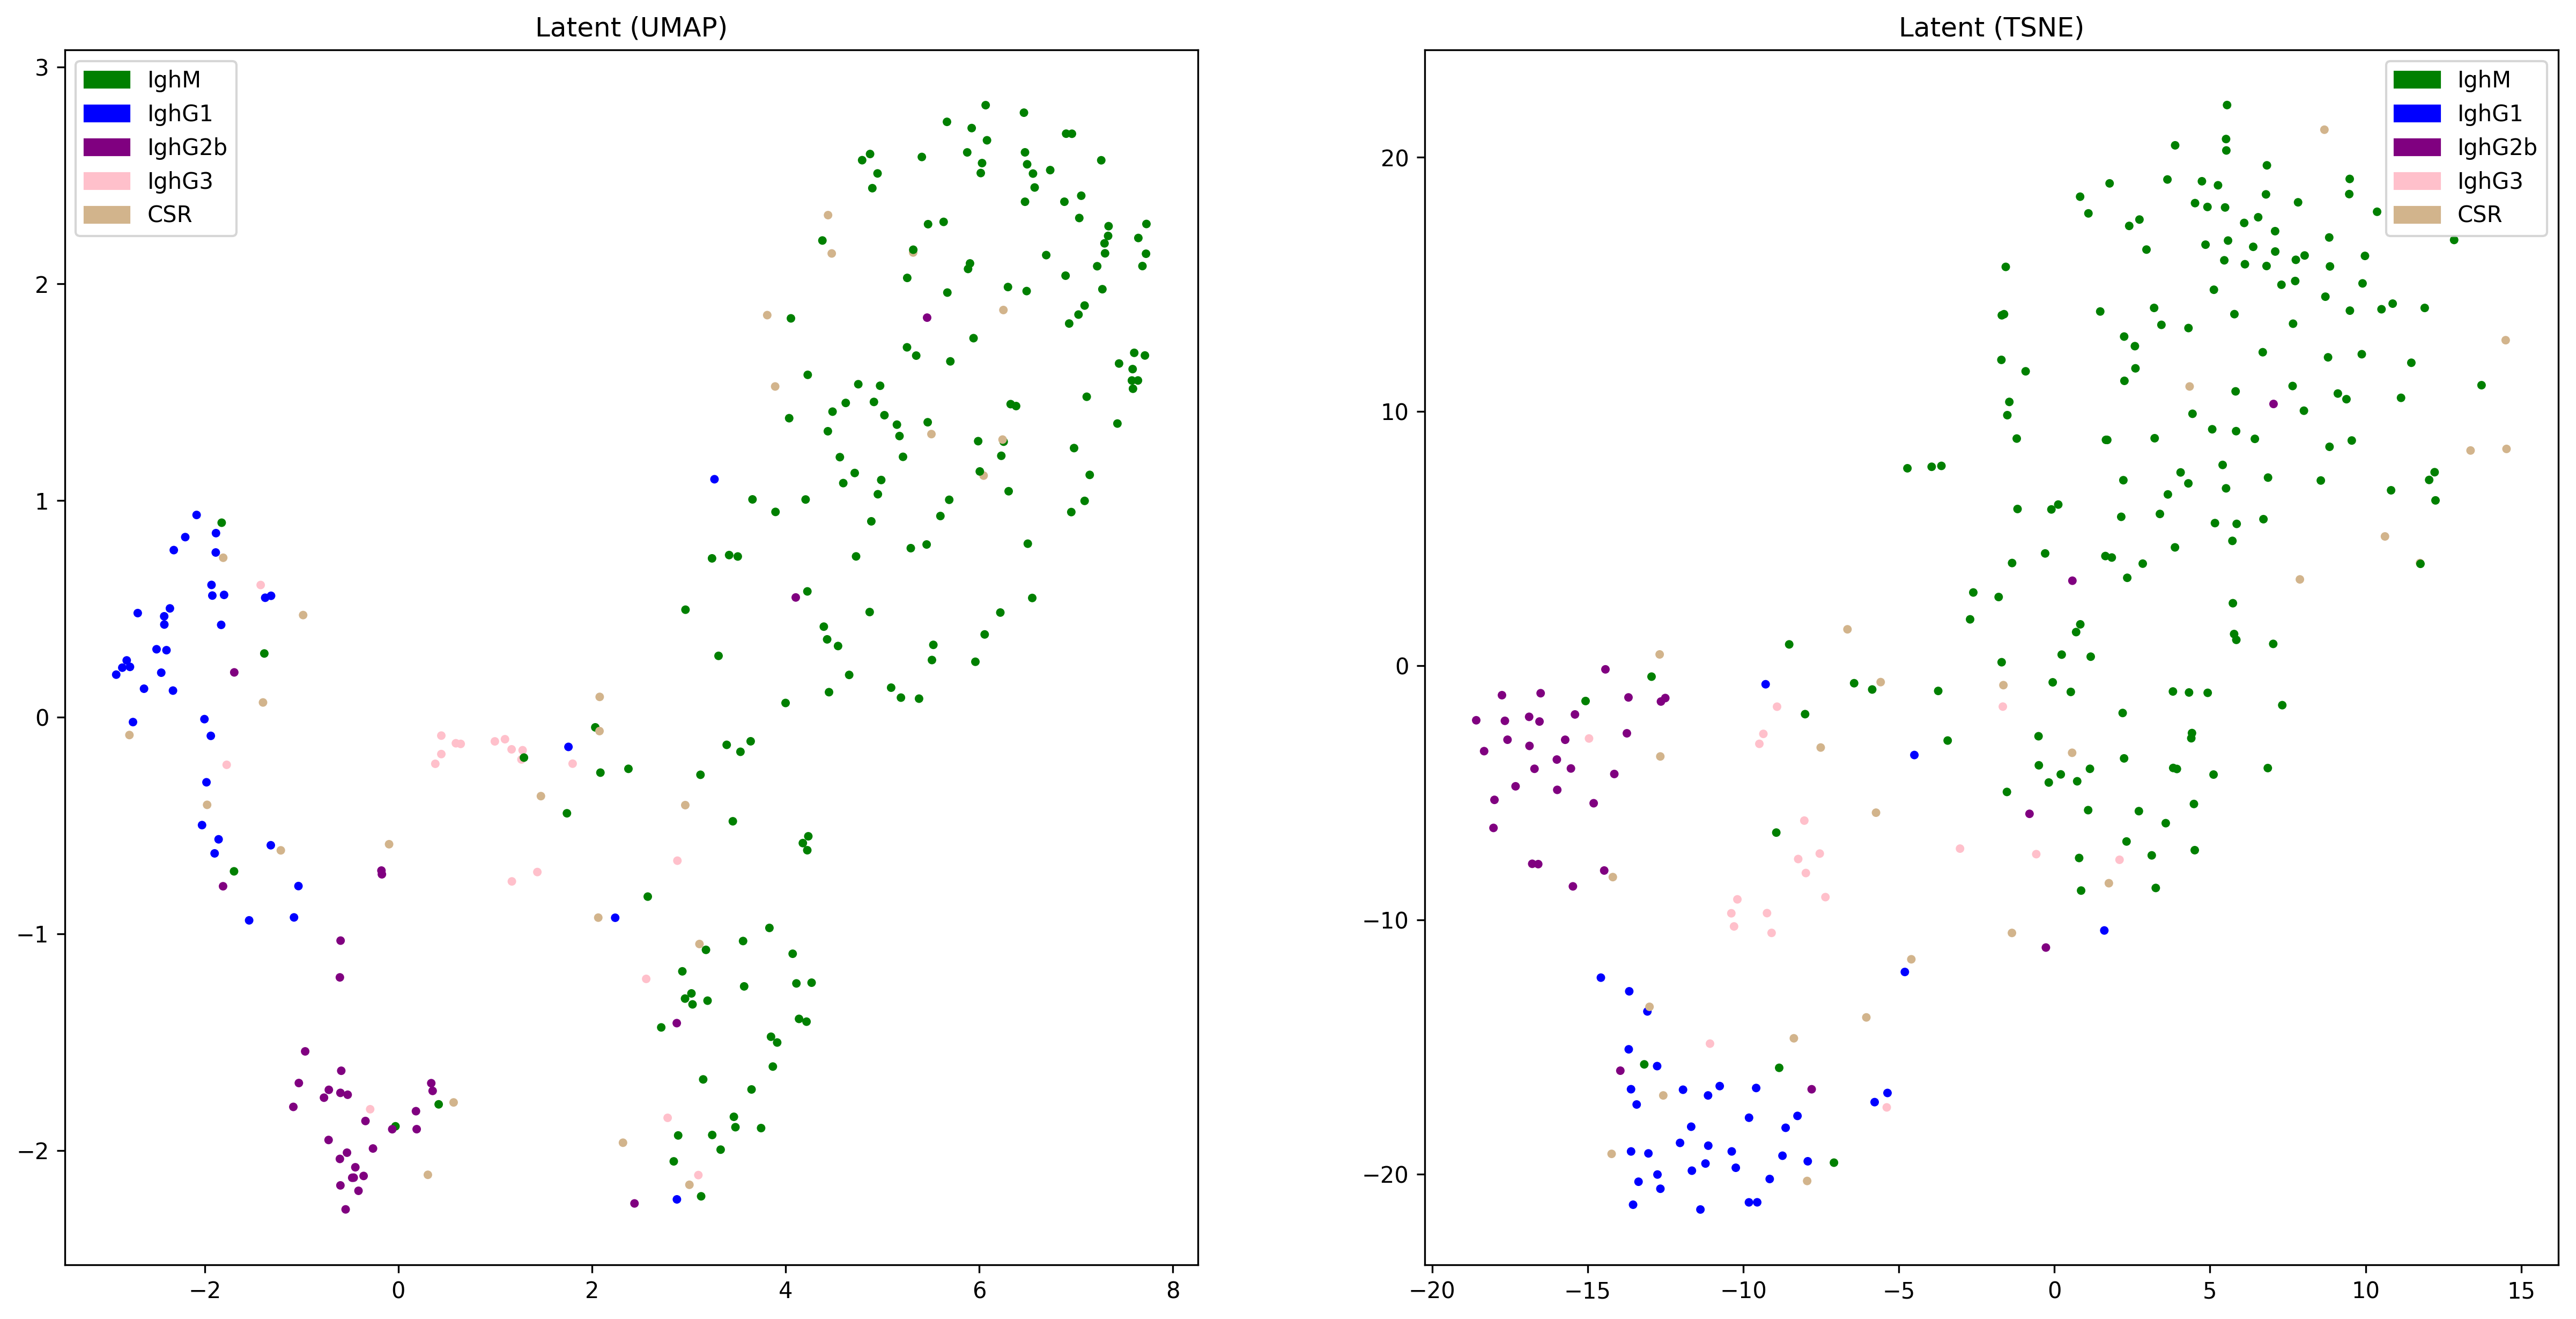

In [18]:

latent = tf.keras.Model(inputs=kl_model.input, outputs=kl_model.get_layer('latent_layer').output)
latent_train = latent.predict(norm_rna_data)
latent_df = pd.DataFrame(data=latent_train, index=sample_list)
latent_df.to_csv("latent_values.tsv", sep="\t")

plt.figure(figsize=(20,10), dpi=300)
plt.subplot(121)
plot_data(latent_train, relative_data, relative_list, "latent", "umap", color_list)
plt.subplot(122)
plot_data(latent_train, relative_data, relative_list, "latent", "tsne", color_list)
plt.show()

## Decoder Model

In [19]:
config.read('config.py')

l2_norm_dec = float(config.get('AE', 'L2_Norm_AE'))
reg_dec = tf.keras.regularizers.l2(l2_norm_dec)

dec_model = tf.keras.Sequential([
    tf.keras.layers.Dense(rna_hidden_dim_2, activation='relu', input_shape=(rna_latent_dim,),
        kernel_regularizer=reg_dec, bias_regularizer=reg_dec),
    tf.keras.layers.BatchNormalization(),
    
    tf.keras.layers.Dense(rna_hidden_dim_1, activation='relu',
        kernel_regularizer=reg_dec, bias_regularizer=reg_dec),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(len(gene_list), activation=None, name='rna_reconstruction',
        kernel_regularizer=reg_dec, bias_regularizer=reg_dec)
])

es_cb_dec = tf.keras.callbacks.EarlyStopping('val_mean_squared_error', patience=100, restore_best_weights=True)
dec_model.compile(optimizer=tf.train.AdamOptimizer(learning_rate_ae), loss=tf.keras.losses.MSE, metrics=['mse'])
dec_model.fit(latent_train, rna_data, epochs=100000, callbacks=[es_cb_dec], validation_split=0.1, 
              verbose=0, batch_size=1024)
dec_model.fit(latent_train, rna_data, epochs=5, verbose=0, batch_size=1024)


## Reconstruction UMAP and tSNE

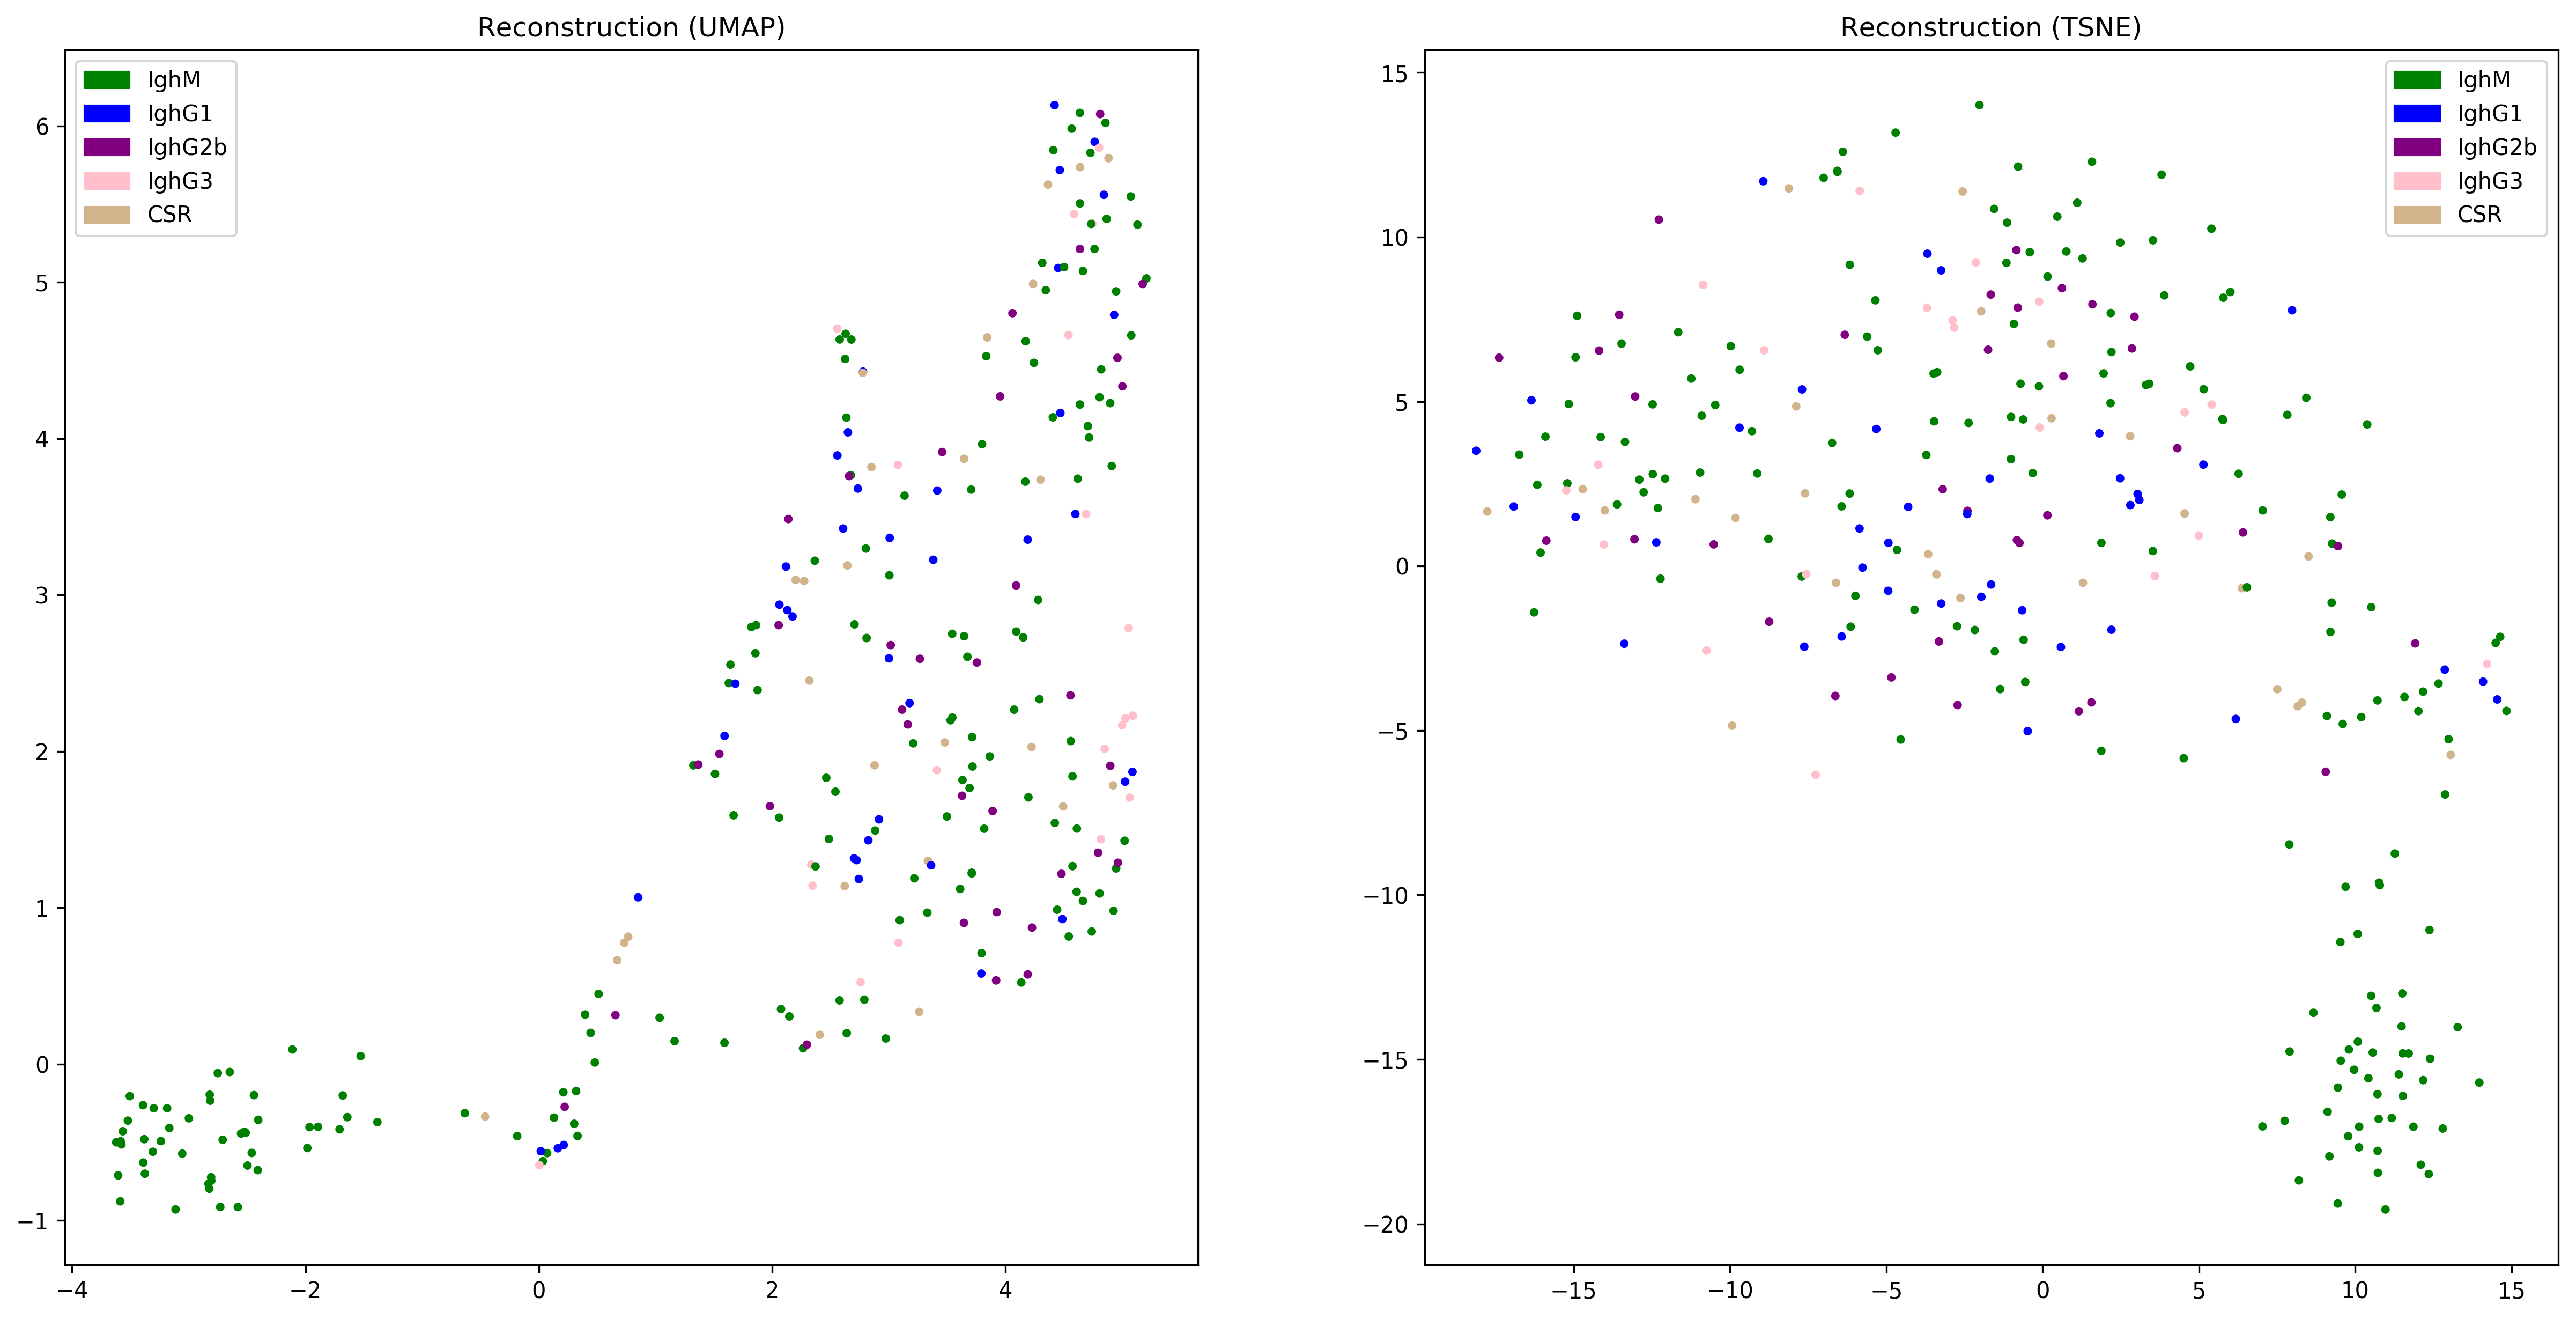

In [20]:
decoded_train = dec_model.predict(latent_train)
decoded_df = pd.DataFrame(data=decoded_train, index=sample_list, columns=gene_list)
decoded_df.to_csv("reconstructed_values.tsv", sep="\t")

plt.figure(figsize=(20,10), dpi=300)
plt.subplot(121)
plot_data(decoded_train, relative_data, relative_list, "reconstruction", "umap", color_list)
plt.subplot(122)
plot_data(decoded_train, relative_data, relative_list, "reconstruction", "tsne", color_list)
plt.show()

## Conditional Generative Adversarial Networks (CGAN)

We use the latent space in order to train a generative model. In this CGAN model, the generator network tries to generate samples that are representative of true data. At the same time, a discriminator network is trained to try to determine real samples from generated samples. The two networks are trained at the same time against each other.

In [21]:
def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random_normal(shape=size, stddev=xavier_stddev)

""" Discriminator Net model """
X = tf.placeholder(tf.float32, shape=[None, rna_latent_dim])
y = tf.placeholder(tf.float32, shape=[None, relative_data.shape[1]])

D_W1 = tf.Variable(xavier_init([rna_latent_dim + relative_data.shape[1], det_dim]))
D_b1 = tf.Variable(tf.zeros(shape=[det_dim]))

D_W2 = tf.Variable(xavier_init([det_dim, 1]))
D_b2 = tf.Variable(tf.zeros(shape=[1]))

theta_D = [D_W1, D_W2, D_b1, D_b2]


def discriminator(x, y):
    inputs = tf.concat(axis=1, values=[x, y])
    D_h1 = tf.nn.relu(tf.matmul(inputs, D_W1) + D_b1)
    D_logit = tf.matmul(D_h1, D_W2) + D_b2
    D_prob = tf.nn.sigmoid(D_logit)

    return D_prob, D_logit

""" Generator Net model """

Z = tf.placeholder(tf.float32, shape=[None, Z_dim])

G_W1 = tf.Variable(xavier_init([Z_dim + relative_data.shape[1], gen_dim1]))
G_b1 = tf.Variable(tf.zeros(shape=[gen_dim1]))

G_W2 = tf.Variable(xavier_init([gen_dim1, gen_dim2]))
G_b2 = tf.Variable(tf.zeros(shape=[gen_dim2]))

G_W3 = tf.Variable(xavier_init([gen_dim2, rna_latent_dim]))
G_b3 = tf.Variable(tf.zeros(shape=[rna_latent_dim]))

theta_G = [G_W1, G_W2, G_W3, G_b1, G_b2, G_b3]

def generator(z, y):
    inputs = tf.concat(axis=1, values=[z, y])
    G_h1 = tf.nn.relu(tf.matmul(inputs, G_W1) + G_b1)
    G_h2 = tf.nn.relu(tf.matmul(G_h1, G_W2) + G_b2)
    G_log_prob = tf.matmul(G_h2, G_W3) + G_b3
    G_prob = tf.nn.sigmoid(G_log_prob)

    return G_log_prob, G_prob

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])
reg_dec = tf.keras.regularizers.l2(l2_norm_cgan)

## CGAN Training

Here we train the CGAN model for 50,000 epochs.

In [23]:

G_sample, G_sample_sigmoid = generator(Z, y)
D_real, D_logit_real = discriminator(X, y)
D_fake, D_logit_fake = discriminator(G_sample, y)

D_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_real, labels=tf.ones_like(D_logit_real)))
D_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.zeros_like(D_logit_fake)))
D_loss = D_loss_real + D_loss_fake

G_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=D_logit_fake, labels=tf.ones_like(D_logit_fake)))

D_solver = tf.train.AdamOptimizer(learning_rate=learning_rate_cgan).minimize(D_loss, var_list=theta_D)
G_solver = tf.train.AdamOptimizer(learning_rate=learning_rate_cgan).minimize(G_loss, var_list=theta_G)

train_relative = relative_data
train_latent = latent_train

train = tf.data.Dataset.from_tensor_slices((train_latent, train_relative))
train = train.batch(1024)
train = train.shuffle(1000000)

train_iterator = train.make_initializable_iterator()
train_next_element = train_iterator.get_next()

sess = tf.Session()
sess.run(tf.global_variables_initializer())

for it in range(50000+1):

    sess.run(train_iterator.initializer)
    batches = 0
    total_g_loss = 0
    total_d_loss = 0
    while True:
        try:
            X_mb, y_mb = sess.run(train_next_element)
            noise = np.random.normal(loc=0,scale=0.02,size=y_mb.shape[0]*y_mb.shape[1])
            y_mb = np.clip(y_mb + noise.reshape(y_mb.shape[0], y_mb.shape[1]),0,1)
            sums = np.sum(y_mb,1)
            y_mb = y_mb/sums.reshape(-1,1)
            batches += 1
            Z_sample = sample_Z(X_mb.shape[0], Z_dim)
            _, D_loss_curr = sess.run([D_solver, D_loss], feed_dict={X: X_mb, Z: Z_sample, y:y_mb})
            _, G_loss_curr, samp = sess.run([G_solver, G_loss, G_sample], feed_dict={Z: Z_sample, y:y_mb})
        except tf.errors.OutOfRangeError:
            print(" %d\tGen Loss: %.3f\tDisc Loss: %.3f" % (it, G_loss_curr, D_loss_curr), end="\r")
            break

<Figure size 432x432 with 0 Axes>

## Generate Synthetic Data

Using the trained generator network, we generate data points representing gradual differentiation from 100% IghM to 0% IghM for each target differentiation path. We generate 100 samples at each step, and each step differs from the next by 1% IghM.

In [38]:
num_gen = 100

step = 1
y_sample = []

for i in range(0,101,step):
        
    for j in range(num_gen):
        ighm = 1 - i/100.0
        ighg1 = i/100.0
        ighg2b = 0
        ighg2c = 0
        ighg3 = 0
        igha = 0
        ighd = 0
        ighe = 0
        s = ighm + ighg1 + ighg2b + ighg2c + ighg3 + igha + ighe + ighd

        ighgm = ighm/s
        ighg1 = ighg1/s
        ighg2b = ighg2b/s
        ighg2c = ighg2c/s
        ighg3 = ighg3/s
        igha = igha/s
        ighd = ighd/s
        ighe = ighe/s
    
        y_sample.append([igha,ighd,ighe,ighg1,ighg2b,ighg2c,ighg3,ighm])

y_sample = np.array(y_sample)
Z_sample = sample_Z(y_sample.shape[0], Z_dim)

ighg1_gen_data = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

data_df = pd.DataFrame(ighg1_gen_data)
y_df = pd.DataFrame(y_sample)

data_df.to_csv("generated_data/generated_data_ighg1.csv")
y_df.to_csv("generated_data/generated_relative_ighg1.csv")


y_sample = []

for i in range(0,101,step):
    
    for j in range(num_gen):
        ighm = 1 - i/100.0
        ighg2b = i/100.0
        ighg1 = 0
        ighg2c = 0
        ighg3 = 0
        igha = 0
        ighd = 0
        ighe = 0
        s = ighm + ighg1 + ighg2b + ighg2c + ighg3 + igha + ighe + ighd
    
        ighgm = ighm/s
        ighg1 = ighg1/s
        ighg2b = ighg2b/s
        ighg2c = ighg2c/s
        ighg3 = ighg3/s
        igha = igha/s
        ighd = ighd/s
        ighe = ighe/s
    
        y_sample.append([igha,ighd,ighe,ighg1,ighg2b,ighg2c,ighg3,ighm])

y_sample = np.array(y_sample)
Z_sample = sample_Z(y_sample.shape[0], Z_dim)

ighg2b_gen_data = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

data_df = pd.DataFrame(ighg2b_gen_data)
y_df = pd.DataFrame(y_sample)

data_df.to_csv("generated_data/generated_data_ighg2b.csv")
y_df.to_csv("generated_data/generated_relative_ighg2b.csv")




y_sample = []


for i in range(0,101,step):
    
    for j in range(num_gen):

        ighm = 1 - i/100.0
        ighg3 = i/100.0
        ighg2b = 0
        ighg2c = 0
        ighg1 = 0
        igha = 0
        ighd = 0
        ighe = 0
        s = ighm + ighg1 + ighg2b + ighg2c + ighg3 + igha + ighe + ighd

        ighgm = ighm/s
        ighg1 = ighg1/s
        ighg2b = ighg2b/s
        ighg2c = ighg2c/s
        ighg3 = ighg3/s
        igha = igha/s
        ighd = ighd/s
        ighe = ighe/s
    
        y_sample.append([igha,ighd,ighe,ighg1,ighg2b,ighg2c,ighg3,ighm])

y_sample = np.array(y_sample)
Z_sample = sample_Z(y_sample.shape[0], Z_dim)

ighg3_gen_data = sess.run(G_sample, feed_dict={Z: Z_sample, y:y_sample})

data_df = pd.DataFrame(ighg3_gen_data)
y_df = pd.DataFrame(y_sample)

data_df.to_csv("generated_data/generated_data_ighg3.csv")
y_df.to_csv("generated_data/generated_relative_ighg3.csv")

## Decode Synthetic Latent Space

Using the decoder model, we can decode the generated latent spaces and save them.

In [41]:
decoded_ighg1 = dec_model.predict(ighg1_gen_data)
decoded_df = pd.DataFrame(data=decoded_ighg1, columns=gene_list)
decoded_df.to_csv("generated_data/generated_data_ighg1_decoded.csv")

decoded_ighg2b = dec_model.predict(ighg2b_gen_data)
decoded_df = pd.DataFrame(data=decoded_ighg2b, columns=gene_list)
decoded_df.to_csv("generated_data/generated_data_ighg2b_decoded.csv")

decoded_ighg3 = dec_model.predict(ighg3_gen_data)
decoded_df = pd.DataFrame(data=decoded_ighg3, columns=gene_list)
decoded_df.to_csv("generated_data/generated_data_ighg3_decoded.csv")

## Check Latent CGAN Generated Samples

TSNE and UMAP plots of CGAN generated samples using the observed relative gene expressions.

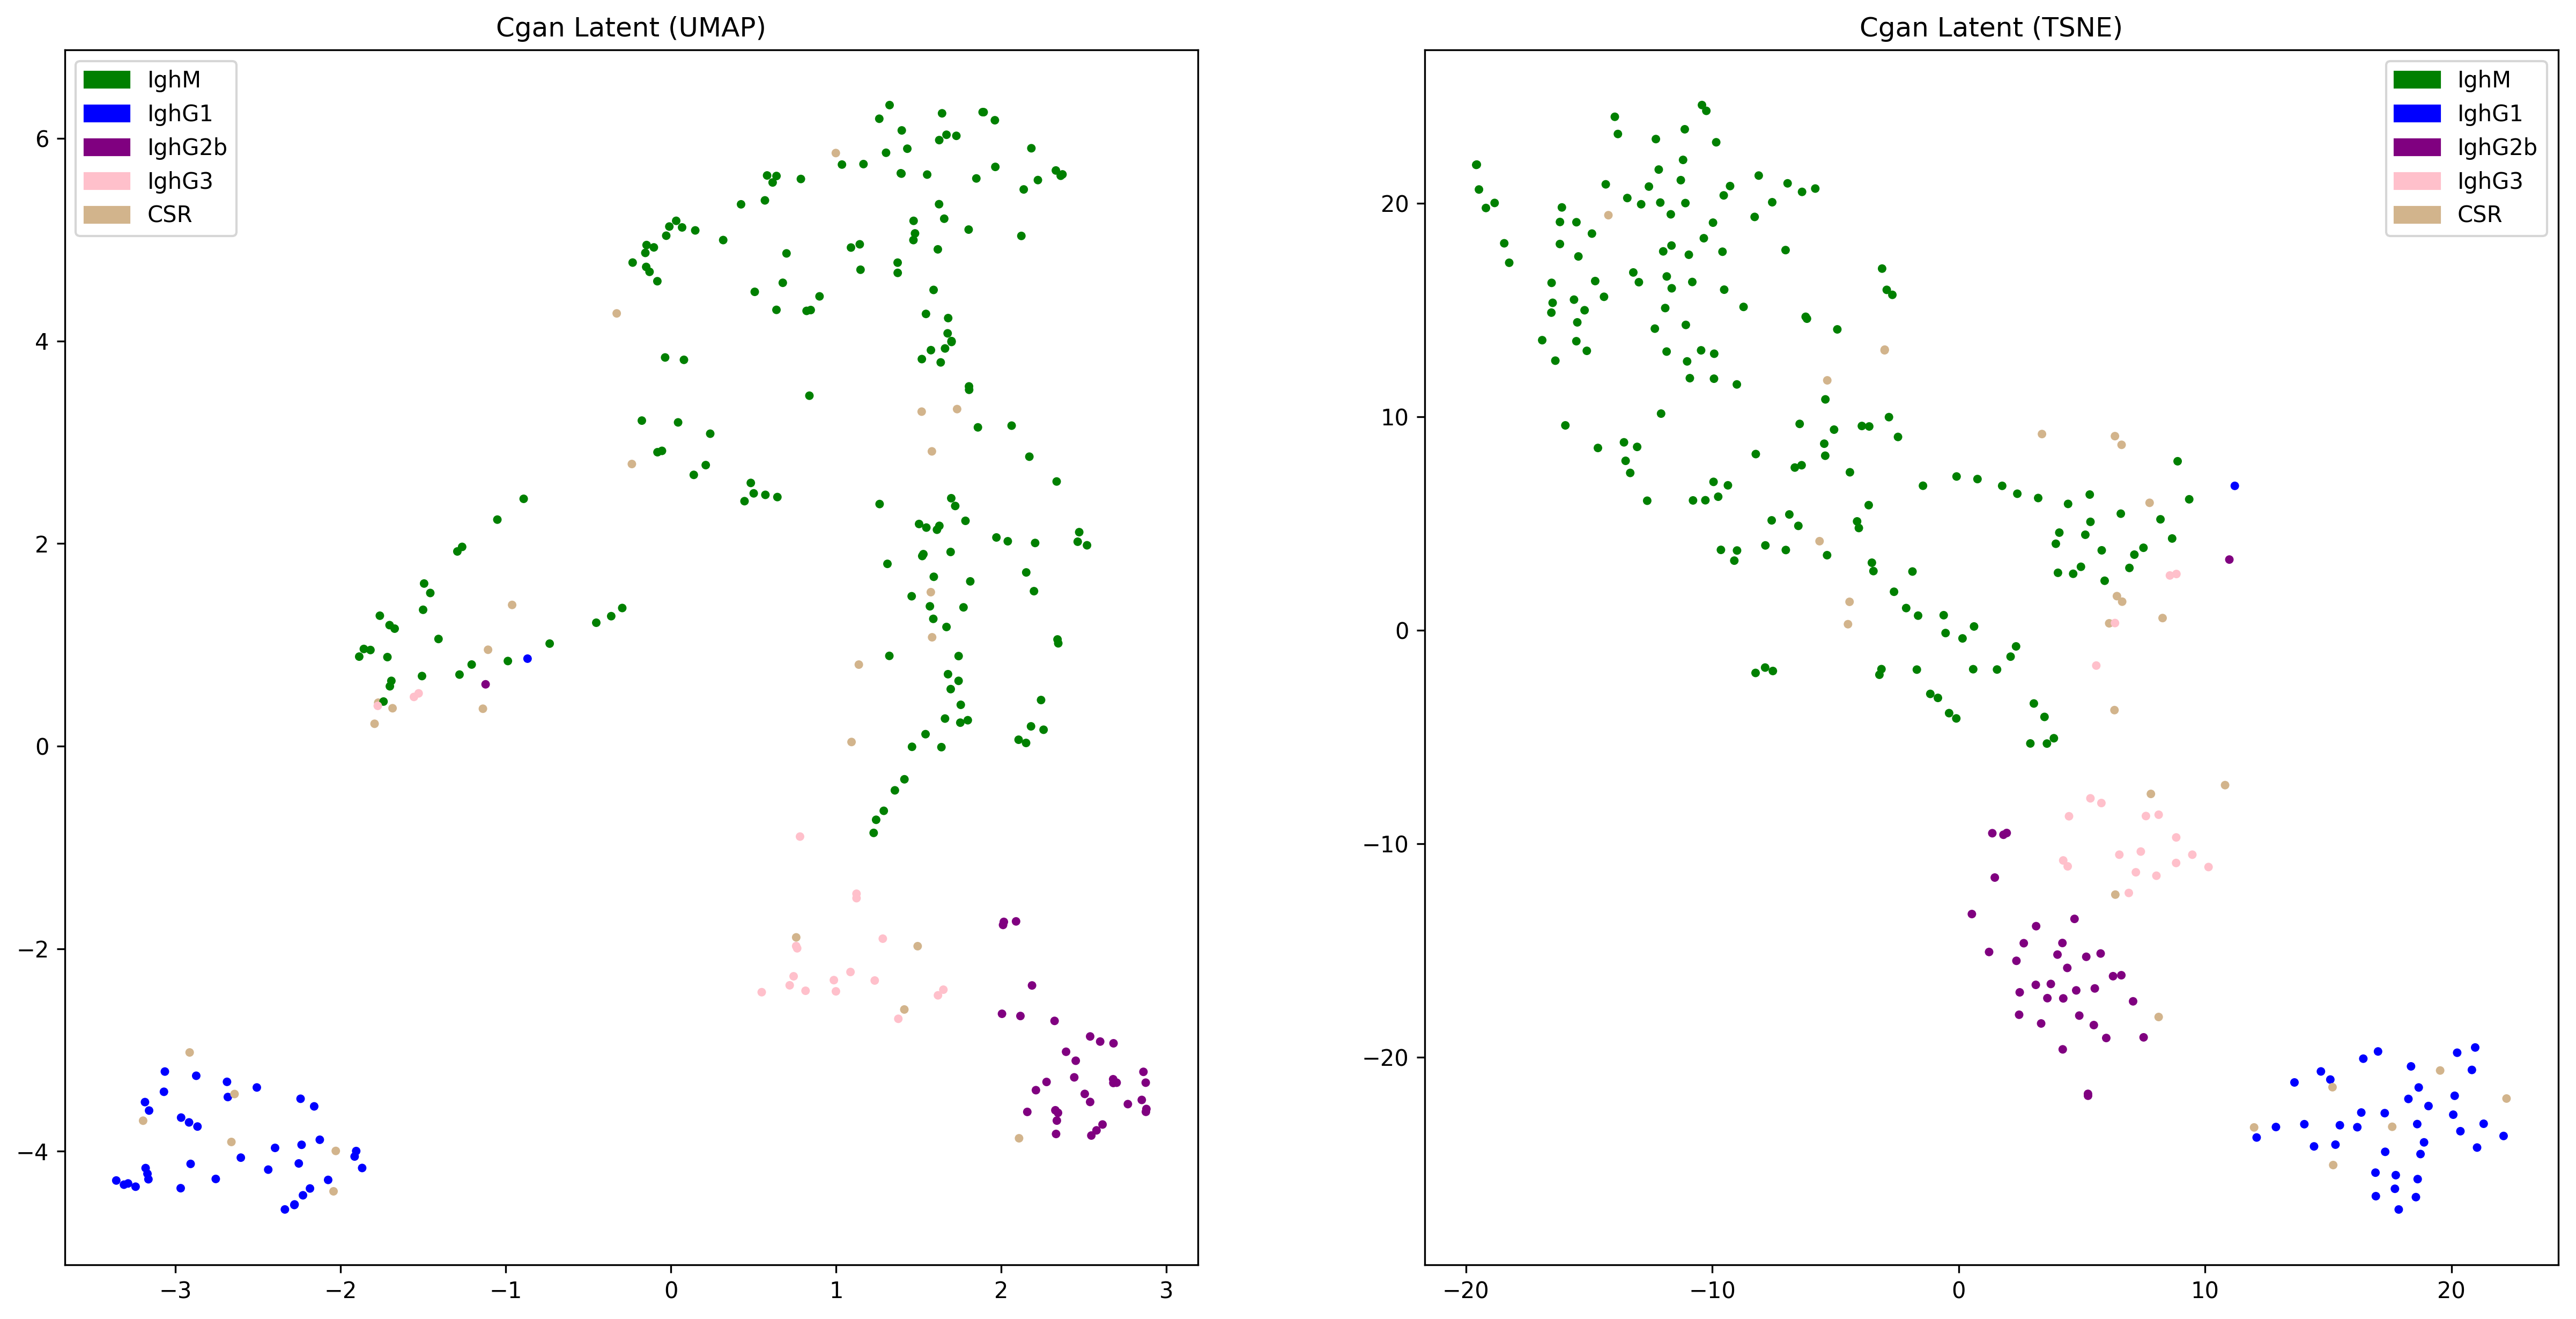

In [44]:
Z_sample = sample_Z(relative_data.shape[0], Z_dim)
gen_data = sess.run(G_sample, feed_dict={Z:Z_sample, y:relative_data})
cgan_latent_df = pd.DataFrame(data=gen_data, index=sample_list)

plt.figure(figsize=(20,10), dpi=300)
plt.subplot(121)
plot_data(gen_data, relative_data, relative_list, "CGAN (Latent)", "umap", color_list)
plt.subplot(122)
plot_data(gen_data, relative_data, relative_list, "CGAN (Latent)", "tsne", color_list)
plt.show()

## Check Decoded CGAN Generated Samples

TSNE and UMAP plots of decoded CGAN generated samples using the observed relative gene expressions.

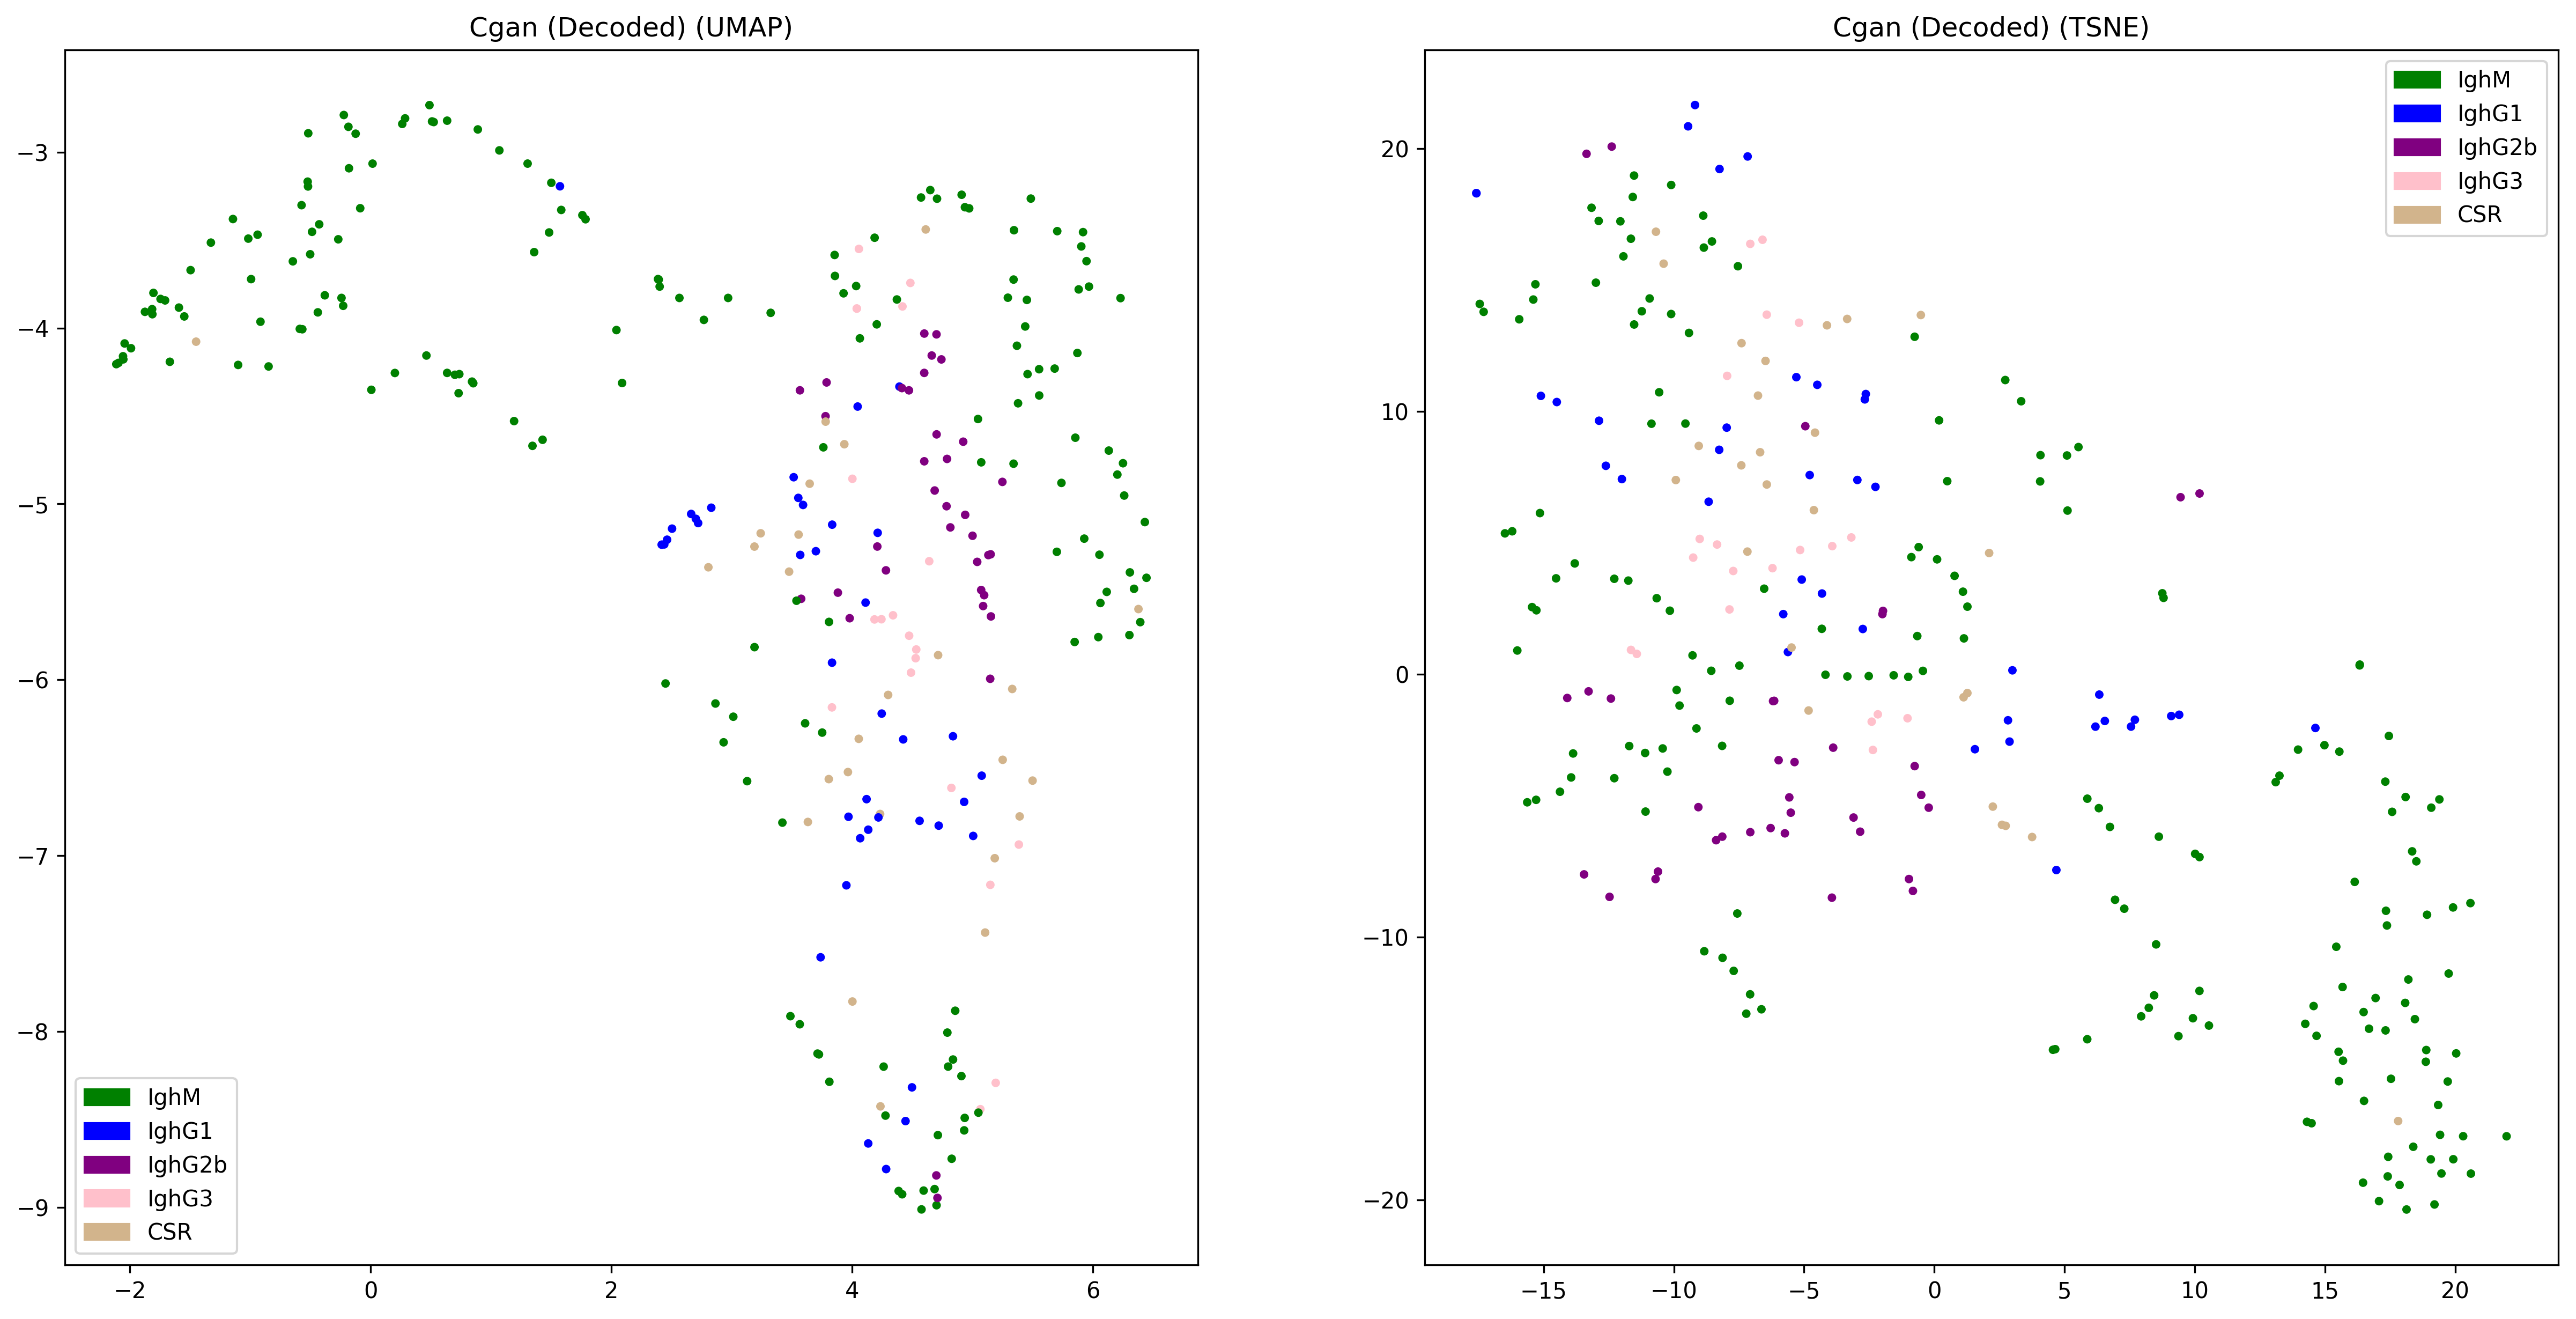

In [45]:
decoded_cgan = dec_model.predict(gen_data)
cgan_decoded_df = pd.DataFrame(data=decoded_cgan, index=sample_list, columns=gene_list)

plt.figure(figsize=(20,10), dpi=300)
plt.subplot(121)
plot_data(decoded_cgan, relative_data, relative_list, "CGAN (Decoded)", "umap", color_list)
plt.subplot(122)
plot_data(decoded_cgan, relative_data, relative_list, "CGAN (Decoded)", "tsne", color_list)
plt.show()